In [1]:
import time
import struct

import chipwhisperer as cw
from chipshouter import ChipSHOUTER
from grbl import Grbl

In [2]:
def as_hex(s):
    return "".join([f"\\x{ord(c):02x}" for c in s])

def make_pkt(data):
    pkt = b"\x01"
    pkt += struct.pack('!H', len(data))
    pkt += data

    # Checksum
    chk = (256 - sum(pkt[1:])) & 0xff
    pkt += bytes([chk, 0x03])

    return pkt

In [3]:
scope = cw.scope()

In [5]:
cs = ChipSHOUTER('/dev/ttyUSB0')

In [6]:
cnc = Grbl('/dev/ttyUSB1')

In [7]:
cs.hwtrig_mode = 1
cs.mute = True

print(cs)

api_version         = 0.0.0
armed               = False
voltage = 
    set      = 500
    measured = 22
pulse = 
    width        = 160
    repeat       = 3
    deadtime     = 10
    actual width = 160
state               = disarmed
faults_current      = []
faults_latched      = ['fault_trigger_glitch']
temperature_mosfet  = 30
temperature_diode   = 24
temperature_xformer = 32
arm_timeout         = 2
hwtrig_term         = False
hwtrig_mode         = True
emode               = False
mute                = True
absent_temp         = 1
pat_enable          = False
pat_wave            = 
reset_config        = 0
reset               = True
board_id            = G2JW70:2.0.3

boot_enable         = 0



In [8]:
scope.default_setup()
scope.io.tio1 = 'serial_tx'
scope.io.tio2 = 'serial_rx'
scope.io.tio3 = 'gpio_low'
scope.io.glitch_trig_mcx = 'trigger'

scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 22                       
scope.gain.db                            changed from 15.0                      to 25.091743119266056       
scope.adc.samples                        changed from 131124                    to 5000                     
scope.clock.clkgen_freq                  changed from 0                         to 7370129.87012987         
scope.clock.adc_freq                     changed from 0                         to 29480519.48051948        
scope.io.tio1                            changed from serial_tx                 to serial_rx                
scope.io.tio2                            changed from serial_rx                 to serial_tx                
scope.io.hs2                             changed from None                      to clkgen                   
scope.io.tio_states

In [9]:
scope.clock.clkgen_src = 'system'
scope.clock.clkgen_freq = 100e6
scope.clock.adc_mul = 0

target = cw.target(scope)
target.baud = 9600
target.flush()

scope.trigger.triggers = 'tio1'
scope.trigger.module = 'UART'
scope.gain.db = 12

scope.UARTTrigger.enabled = True
scope.UARTTrigger.baud = 9600
scope.UARTTrigger.set_pattern_match(0, '\x22\x03\x01\x00\x01\x00\xff\x03') # Synchronize
scope.UARTTrigger.trigger_source = 0

scope.glitch.enabled = True
scope.glitch.clk_src = "pll"

scope.io.glitch_hp = False
scope.io.glitch_lp = True
scope.io.glitch_trig_mcx = 'glitch'

scope.glitch.output = "enable_only"
scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called

(ChipWhisperer Scope WARNING|File ChipWhispererHuskyClock.py:373) ADC frequency must be between 1MHz and 300000000.0MHz - ADC mul has been adjusted to 3
(ChipWhisperer Scope WARNING|File ChipWhispererHuskyClock.py:376) 
                ADC frequency exceeds specification (200 MHz). 
                This may or may not work, depending on temperature, voltage, and luck.
                It may not work reliably.
                You can run scope.adc_test() to check whether ADC data is sampled properly by the FPGA,
                but this doesn't fully verify that the ADC is working properly.
                You can adjust scope.clock.pll._warning_freq if you don't want
                to see this message anymore.
                
(ChipWhisperer Scope WARNING|File TraceWhisperer.py:1365) Coudln't achieve exact desired frequency (195160720.825195); setting to 195003697.013855 instead.


In [10]:
def read_block(target, block):
    start, end = block

    print("reading flash", hex(start), hex(end))
    pkt = make_pkt(b'\x15' + struct.pack('>II', start, end))

    target.write(pkt)   
    resp = target.read(6)
    if resp != '\x81\x00\x01\x15\xea\x03':
        print("wrong ack", as_hex(resp))
        return None

    rem = end - start
    dat = b""
    
    while rem > 0:
        target.write(b'\x81\x00\x01\x15\xea\x03')
        length = target.read(3)
        
        if len(length) != 3:
            print("wrong length received", as_hex(length))
            return None
        
        length = bytes([ord(c) for c in length])
        length = struct.unpack('!H', length[1:])[0] - 1 # Data starts with 0x15

        resp = b""
        while len(resp) < length + 3: 
            resp += bytes([ord(c) for c in target.read(target.in_waiting())])
            time.sleep(0.05)

        dat += resp[1:-2]
        rem -= length
    return dat

In [20]:
gc = cw.GlitchController(groups=["success", "reset", "normal", "assert"], parameters=["x", "y", "ext_offset", "repeat"])
min_delay = int(8.5e-6 * scope.clock.clkgen_freq)
max_delay = int(10.5e-6 * scope.clock.clkgen_freq)

print(min_delay, max_delay)

gc.set_range("x", 0, 8)
gc.set_range("y", 0, 8)
gc.set_range("ext_offset", min_delay, max_delay)
# gc.set_range("voltage", 250, 500) 
gc.set_range("repeat", 2, 10) 

gc.set_global_step(1)
gc.set_step("ext_offset", 20)
# gc.set_step("width", 80)

gc.display_stats()
gc.glitch_plot(plotdots={"assert":'xb', "normal":'xg', "reset":"xy", "success":"+ r"})


850 1050


IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

IntText(value=0, description='assert count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='x setting:', disabled=True, max=8.0, readout_form…

FloatSlider(value=0.0, continuous_update=False, description='y setting:', disabled=True, max=8.0, readout_form…

FloatSlider(value=850.0, continuous_update=False, description='ext_offset setting:', disabled=True, max=1050.0…

FloatSlider(value=2.0, continuous_update=False, description='repeat setting:', disabled=True, max=10.0, min=2.…

:DynamicMap   []
   :Overlay
      .Points.I   :Points   [x,y]
      .Points.II  :Points   [x,y]
      .Points.III :Points   [x,y]
      .Points.IV  :Points   [x,y]

In [21]:
def reset_shouter():
    cs.armed = 0
    cs.hwtrig_mode = 1
    cs.faults_current = 0
    cs.pat_enable = False
    cs.voltage = 250

    # cs.pulse.width = 160
    # cs.pulse.repeat = 5
    # cs.pulse.deadtime = 1

    while not cs.armed:
        cs.faults_current = 0
        cs.armed = 1

        print("waiting for arm")
        print(cs)
        time.sleep(1)

reset_shouter()


blocks = [(0x0, 0x1fff)]


while True:
    for x, y, delay, repeat in gc.glitch_values(clear=False):
        # print(cs.pulse)
        # print(cs.voltage)
        cnc.set_pos(x, y)        
        scope.glitch.ext_offset = delay
        scope.glitch.repeat = repeat
        
        if not cs.armed:
            print(cs)
            reset_shouter()
            
        scope.arm()
        # print(scope.trace.capture.triggers_generated)
        

        scope.io.tio3 = 'gpio_high' # Release Reset
        time.sleep(.5)

        
        target.read(target.in_waiting()) # Clean all bytes in serial input buffer

        try:
            # Sync
            target.write(b'\x00' * 10)
            assert target.read(1) == '\x00', "Sync Err"

            # Connect
            target.write(b'\x55')
            assert target.read(1) == '\xc1', "Connect errr"

            # Get device type
            target.write(b'\x01\x00\x01\x38\xc7\x03')
            assert target.read(6) == '\x81\x00\x01\x38\xc7\x03', "Wrong Resp Device Type 1"

            target.write(b'\x81\x00\x01\x38\xc7\x03')
            resp = target.read(30)
            if resp != '\x81\x00\x19\x38\x10\x01\xff\x40\x04\x28\x2c\x00\x01\x6e\x36\x00\x00\x7a\x12\x00\x07\x27\x0e\x00\x00\xf4\x24\x00\x82\x03':
                print("unexpected resp device type 2", as_hex(resp))

            # Set up frequencies
            target.write(make_pkt(b'\x32\x00\xf4\x24\x00\x07\x27\x0e\x00'))

            resp = target.read(6)
            if resp != '\x81\x00\x01\x32\xcd\x03':
                print("wrong resp freq 1", as_hex(resp))  

            target.write(b'\x81\x00\x01\x32\xcd\x03')
            resp = target.read(14)
            if resp != '\x81\x00\x09\x32\x07\x27\x0e\x00\x01\xc9\xc3\x80\x7c\x03':
                print("unexpected resp freq 2", as_hex(resp.hex))

            # Set bitrate (9600 baud)
            target.write(b'\x01\x00\x05\x34\x00\x00\x25\x80\x22\x03')
            resp = target.read(6)
            if resp != '\x81\x00\x01\x34\xcb\x03':
                print("wrong resp bitrate 1", as_hex(resp))

            # Synchronize!
            target.write(b'\x01\x00\x01\x00\xff\x03')
            resp = target.read(7)


            if resp == '\x81\x00\x01\x00\xff\x03':
                print(x, y, delay, repeat, "ok")
                resp = read_block(target, blocks[0])  
                if resp is not None:
                    print("Got", len(resp))
                    #raise RuntimeError("DONE!")
                    gc.add("success")
                else:
                    gc.add("reset")
            elif resp == '\x81\x00\x02\x80\xdc\xa2\x03': # Programmer Disabled
                gc.add("normal")
                continue
            elif resp == '\x81\x00\x02\x80\xc1\xbd\x03': # Packet error
                gc.add("reset")
                continue    
            elif resp == '\x81\x00\x02\x80\xc3\xbb\x03': # Flow error
                gc.add("reset")
                continue   
            elif resp == '':
                gc.add("reset")
                continue
            else:
                # print(delay, width, "wrong resp synchronize", as_hex(resp))
                gc.add("reset")
                continue


        except AssertionError as e:
            print(e)
            gc.add("assert")

        finally:
            scope.io.tio3 = 'gpio_low' # Assert reset
            time.sleep(1.0)




waiting for arm
api_version         = 0.0.0
armed               = False
voltage = 
    set      = 250
    measured = 25
pulse = 
    width        = 160
    repeat       = 3
    deadtime     = 10
    actual width = 160
state               = arming
faults_current      = []
faults_latched      = []
temperature_mosfet  = 27
temperature_diode   = 23
temperature_xformer = 29
arm_timeout         = 2
hwtrig_term         = False
hwtrig_mode         = True
emode               = False
mute                = True
absent_temp         = 1
pat_enable          = False
pat_wave            = 
reset_config        = 0
reset               = False
board_id            = G2JW70:2.0.3

boot_enable         = 0

Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err
Sync Err


KeyboardInterrupt: 

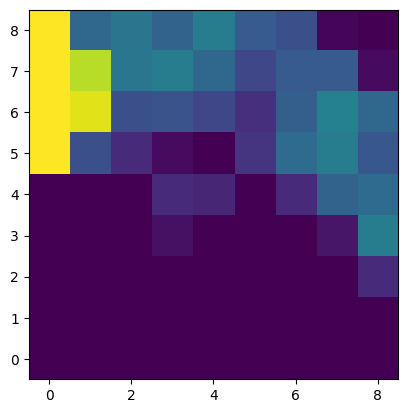

In [44]:
import matplotlib.pyplot as plt
import numpy as np


xs = []
ys = []
mp = np.zeros((9, 9))

for k, v in gc.results._result_dict.items():
    if v['reset']:
        x, y, delay, repeat = k
        # print(k, v)
        xs.append(x)
        ys.append(y)
        mp[y, x] += 1

# plt.plot(xs, ys, 'x')
plt.imshow(mp, origin='lower')

# Notes:
# Upper half of the chip seems to work best